In [1]:
import os
import copy

import pcl
import pyntcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
seq_list = {
  0 : "unlabeled",
  1 : "outlier",
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  40: "road",
  44: "parking",
  48: "sidewalk",
  49: "other-ground",
  50: "building",
  51: "fence",
  52: "other-structure",
  60: "lane-marking",
  70: "vegetation",
  71: "trunk",
  72: "terrain",
  80: "pole",
  81: "traffic-sign",
  99: "other-object",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [3]:
obstacle_lst = {
  10: "car",
  11: "bicycle",
  13: "bus",
  15: "motorcycle",
  16: "on-rails",
  18: "truck",
  20: "other-vehicle",
  30: "person",
  31: "bicyclist",
  32: "motorcyclist",
  252: "moving-car",
  253: "moving-bicyclist",
  254: "moving-person",
  255: "moving-motorcyclist",
  256: "moving-on-rails",
  257: "moving-bus",
  258: "moving-truck",
  259: "moving-other-vehicle"
}

In [4]:
scan = np.fromfile('dataset/sequences/00/velodyne/000009.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('dataset/sequences/00/labels/000009.label', dtype=np.uint32)
label = label.reshape((-1))

In [5]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
for seg in unq:
    if seg in list(seq_list.keys()):
        print(seg,seq_list[seg])

0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
72 terrain
40 road
10 car
44 parking
80 pole
81 traffic-sign
50 building
51 fence
52 other-structure
48 sidewalk
60 lane-marking
254 moving-person
255 moving-motorcyclist


In [6]:
scan = scan[:,:3]
scan

array([[57.516327 ,  8.860495 ,  2.1762035],
       [57.860134 ,  9.006442 ,  2.1881773],
       [58.05174  ,  9.22336  ,  2.1951373],
       ...,
       [ 3.8257542, -1.4199586, -1.7649935],
       [ 3.8513634, -1.4169728, -1.7760001],
       [ 3.888965 , -1.4179859, -1.7930062]], dtype=float32)

In [7]:
test_cloud = pyntcloud.PyntCloud(pd.DataFrame(scan,columns=['x','y','z']))

test_cloud.points['seg_id'] = pd.Series(label)

seg_count = test_cloud.points.groupby(test_cloud.points['seg_id']).count()
seg_count['Proportion'] = seg_count['x'] / seg_count['x'].sum() * 100
np.around(seg_count,2)

,x,y,z,Proportion
seg_id,,,,
0,2111,2111,2111,1.74
1,2,2,2,0.00
10,7429,7429,7429,6.12
40,27625,27625,27625,22.76
44,8297,8297,8297,6.84
48,18519,18519,18519,15.26
50,26218,26218,26218,21.60
51,709,709,709,0.58
52,881,881,881,0.73


In [8]:
test_cloud.plot(use_as_color='seg_id', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-1.324129343032837, 45.91697978973389, 3.206…

In [9]:
is_parking = ~test_cloud.points['seg_id'].isin(list(obstacle_lst.keys()))
test_cloud.points['is_parking'] = pd.Series(is_parking)

In [10]:
test_cloud.plot(use_as_color='is_parking', cmap="RdYlGn", output_name="is_parking")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-1.324129343032837, 45.91697978973389, 3.206…

In [11]:
is_parking = test_cloud.points['is_parking'] != 1
test_cloud.apply_filter(is_parking)

In [12]:
test_cloud.plot()

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.5293570756912231, 28.29741406440735, -0.74…

In [13]:
n_voxels = 45
voxelgrid_id = test_cloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=10)

In [14]:
%time cluster_id = test_cloud.add_scalar_field("euclidean_clusters",voxelgrid_id=voxelgrid_id)

CPU times: user 728 ms, sys: 0 ns, total: 728 ms
Wall time: 734 ms


In [15]:
test_cloud.points

,x,y,z,seg_id,is_parking,"clusters(V([45, 45, 10],[None, None, None],True))"
0,33.433826,-1.976104,0.155485,10,False,2.0
1,33.445412,-1.872151,0.155459,10,False,2.0
2,33.480202,-1.821174,0.155446,10,False,2.0
3,33.469784,-1.715222,0.155420,10,False,2.0
4,33.590363,-1.615268,0.154395,10,False,2.0
...,...,...,...,...,...,...
7483,2.526984,-2.474804,-1.497903,10,False,5.0
7484,2.533548,-2.465820,-1.496911,10,False,5.0
7485,2.548357,-2.473824,-1.504912,10,False,5.0
7486,2.756470,-2.534933,-1.594957,10,False,5.0


In [16]:
test_cloud.plot(use_as_color=cluster_id, cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.5293570756912231, 28.29741406440735, -0.74…

In [17]:
test_cloud.points[test_cloud.points.columns[-1]].nunique()

9

In [7]:
def get_bounding_boxes(clusters):
    box_coord_list = []
    for i in range(len(clusters)):
        x_min, x_max, y_min, y_max, z_min, z_max =  list(clusters.iloc[i])
        box = np.zeros([8, 3])
        box[0, :] = [x_min, y_min, z_min]
        box[1, :] = [x_max, y_min, z_min]
        box[2, :] = [x_max, y_max, z_min]
        box[3, :] = [x_min, y_max, z_min]
        box[4, :] = [x_min, y_min, z_max]
        box[5, :] = [x_max, y_min, z_max]
        box[6, :] = [x_max, y_max, z_max]
        box[7, :] = [x_min, y_max, z_max]
        box = np.transpose(box)
        box_coord_list.append(box)
    return box_coord_list

In [8]:
def get_selected_segs(scan, label, obstacle_lst):
    
    # get segment id
    label = [seg & 0xFFFF for seg in label]
    unq = list(set(label))
     
    pcloud = pyntcloud.PyntCloud(pd.DataFrame(scan,columns=['x','y','z']))
    pcloud.points['seg_id'] = pd.Series(label)
    
    is_obstacle = ~pcloud.points['seg_id'].isin(list(obstacle_lst.keys()))
    pcloud.points['is_obstacle'] = pd.Series(is_obstacle)
    
    is_obstacle = pcloud.points['is_obstacle'] != 1
    pcloud.apply_filter(is_obstacle)
    
    return pcloud
    

In [9]:
from datetime import datetime
import time


def pipeline(scan, label, obstacle_lst, n_voxels=40, verbose=False):
    
    # get segment id
    start_time = datetime.now()
    label = [seg & 0xFFFF for seg in label]
    unq = list(set(label))
    print('get segment id: ',datetime.now() - start_time)
    
    # get segments
    start_time = datetime.now()
    if verbose:
        print('get segments')
    pcloud = pyntcloud.PyntCloud(pd.DataFrame(scan,columns=['x','y','z']))
    pcloud.points['seg_id'] = pd.Series(label)
    print('get segments: ',datetime.now() - start_time)
    
    # filter chosen segments
    start_time = datetime.now()
    if verbose:
        print('filter needed segments')
    is_obstacle = ~pcloud.points['seg_id'].isin(list(obstacle_lst.keys()))
    pcloud.points['is_obstacle'] = pd.Series(is_obstacle)
    
    
    #TODO: pandas filter 
    
    is_obstacle = pcloud.points['is_obstacle'] != 1
    pcloud.apply_filter(is_obstacle)
    print('filtering: ',datetime.now() - start_time)
    
    # get voxel grid
    start_time = datetime.now()
    if verbose:
        print('get voxel grid')
    voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=15)
    print('voxel grid: ',datetime.now() - start_time)
    
    # get cluster
    start_time = datetime.now()
    if verbose:
        print('get cluster')
    cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
    print('clustering: ',datetime.now() - start_time)
    
    # get cluster min max
    start_time = datetime.now()
    if verbose:
        print('get cluster min max')
    clusters = pcloud.points.groupby([cluster_id]).agg({ 'x':['min','max'],
                                                         'y':['min','max'],
                                                         'z':['min','max']
                                                       })
    print('min-max cluster points: ',datetime.now() - start_time)
    
    return clusters

In [10]:


def pipeline_optimized(scan, label, obstacle_lst, n_voxels=40, verbose=False):
    
    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])
    pcloud.seg_id = pcloud.seg_id.astype('uint32')
    pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
    print('get segments: ',datetime.now() - start_time)
    
    # filter chosen segments
    start_time = datetime.now()
    if verbose:
        print('filter needed segments')
    pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
    pcloud = pyntcloud.PyntCloud(pcloud)
    print('filtering: ',datetime.now() - start_time)
    
    print(pcloud.points.seg_id.unique())
    # get voxel grid
    start_time = datetime.now()
    if verbose:
        print('get voxel grid')
    voxelgrid_id = pcloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=15)
    print('voxel grid: ',datetime.now() - start_time)
    
    # get cluster
    start_time = datetime.now()
    if verbose:
        print('get cluster')
    cluster_id = pcloud.add_scalar_field("euclidean_clusters", voxelgrid_id=voxelgrid_id)
    print('clustering: ',datetime.now() - start_time)
    
    # get cluster min max
    start_time = datetime.now()
    if verbose:
        print('get cluster min max')
    clusters = pcloud.points.groupby([cluster_id]).agg({ 'x':['min','max'],
                                                         'y':['min','max'],
                                                         'z':['min','max']
                                                       })
    print('min-max cluster points: ',datetime.now() - start_time)
    
    return clusters

In [17]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN
# clustering = AgglomerativeClustering().fit(X)

def pipeline_separate_clustering(scan, label, obstacle_lst, n_voxels=40,
                                 tol_distance=1, verbose=False):
    
    # get segment id
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan,label.reshape(len(label), 1)), axis=1), 
                          columns=['x', 'y', 'z', 'seg_id'])
    pcloud.seg_id = pcloud.seg_id.astype('uint32')
    pcloud.seg_id = pcloud.seg_id.apply(lambda x: x & 0xFFFF)
    print('get segments: ',datetime.now() - start_time)
    
    # filter chosen segments
    start_time = datetime.now()
    if verbose:
        print('filter needed segments')
    pcloud = pcloud[pcloud['seg_id'].isin(list(obstacle_lst.keys()))]
    print('filtering: ',datetime.now() - start_time)
    
   
    start_time = datetime.now()
    unq_seg = list(pcloud.seg_id.unique())
    print('get unique: ',datetime.now() - start_time)    
    
    clusters = pd.DataFrame.from_dict({('x', 'min'):[],('x', 'max'):[],
                                       ('y', 'min'):[],('y', 'max'):[],
                                       ('z', 'min'):[],('z', 'max'):[]})
    for seg in unq_seg:
        start_time = datetime.now()
        cloud = pcloud[pcloud.seg_id == seg]
        print('Cloud size: ', len(cloud))
#         clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=tol_distance, 
#                                              compute_full_tree=False)
        clustering = DBSCAN(eps=tol_distance)
        clustering.fit(cloud[['x', 'y', 'z']].values)
        cloud['cluster_id'] = clustering.labels_
        cluster = cloud.groupby(['cluster_id']).agg({ 'x':['min', 'max'],
                                                      'y':['min', 'max'],
                                                      'z':['min', 'max']
                                                    })
        cluster = cluster.reset_index(drop=True)
        clusters = clusters.append(cluster)
        print('clustering ', str(seg), ':', datetime.now() - start_time, 'cluster size: ', len(cluster))
    return clusters

## Pipeline implementation

In [12]:
%time 
scan = np.fromfile('dataset/sequences/00/velodyne/000075.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:,:3]

label = np.fromfile('dataset/sequences/00/labels/000075.label', dtype=np.uint32)
label = label.reshape((-1))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs


In [13]:
%time clusters = pipeline(scan, label, obstacle_lst)

get segment id:  0:00:00.654156
get segments:  0:00:00.094115
filtering:  0:00:00.005955
voxel grid:  0:00:00.005621
clustering:  0:00:00.444520
min-max cluster points:  0:00:00.012992
CPU times: user 1.23 s, sys: 0 ns, total: 1.23 s
Wall time: 1.24 s


In [14]:
box_coord_list = get_bounding_boxes(clusters)
print(len(box_coord_list))

15


In [28]:
%time clusters = pipeline_optimized(scan, label, obstacle_lst, n_voxels=30)

get segments:  0:00:00.115139
filtering:  0:00:00.004527
[ 10  11  20 253]
voxel grid:  0:00:00.001490
clustering:  0:00:00.414215
min-max cluster points:  0:00:00.012799
CPU times: user 546 ms, sys: 0 ns, total: 546 ms
Wall time: 551 ms


In [15]:
box_coord_list = get_bounding_boxes(clusters)
print(len(box_coord_list))

15


In [18]:
%time clusters = pipeline_separate_clustering(scan, label, obstacle_lst, tol_distance=5)

get segments:  0:00:00.129277
filtering:  0:00:00.003228
get unique:  0:00:00.000530
Cloud size:  18918
clustering  10 : 0:00:04.276630 cluster size:  12
Cloud size:  20
clustering  11 : 0:00:00.031250 cluster size:  1
Cloud size:  193
clustering  20 : 0:00:00.019525 cluster size:  3
Cloud size:  2
clustering  253 : 0:00:00.019326 cluster size:  1
CPU times: user 2.07 s, sys: 507 ms, total: 2.57 s
Wall time: 4.5 s


In [19]:
box_coord_list = get_bounding_boxes(clusters)
print(len(box_coord_list))

17


In [20]:
clusters

x                     y                    z          
          min        max        min        max       min       max
0   38.350582  40.843315  -4.716749  -3.897984 -0.811084  0.327836
1   26.205044  38.301239   4.045939   8.650812 -1.415163  0.158305
2   27.376738  31.676863  -5.416587  -3.527070 -1.225881  0.161003
3   46.923409  47.579887   3.562080   5.373614 -0.461743 -0.164400
4    0.017316  11.530399  -4.692671  -2.368799 -1.649783  0.178858
5   21.463499  22.585886 -12.115805 -11.623048 -0.762755  0.006316
6  -28.053024 -23.634035  -4.047928  -1.880474 -2.322454 -0.406941
7    0.415404  12.964743   4.149782   8.632913 -1.844203 -0.095036
8  -38.260761 -36.691975   5.476409   7.202608 -2.167003 -1.068180
9  -29.282331 -25.518436   5.238291   8.883007 -2.367408 -0.850633
10  -9.957493  -5.784139   5.083903   9.119674 -2.048266 -0.535907
11 -10.333164  -6.137193  -4.409347  -2.659440 -1.957415 -0.548420
0   29.364283  34.327297  -7.563038  -6.906184 -0.776444 -0.063589
0  -30.475742 -29.757292  11.482147  11.801077 -2.365942 -1.819968
1    8.828778   9.846492  10.148688  10.707556 -1.445127 -0.761118
2  -14.683311 -11.956845  -3.914869  -2.613765 -2.009007 -1.351859
0    2.486060   2.554691  -0.482745   0.465752 -0.918633 -0.911295

In [21]:
# box_coord_list

In [29]:
# axes_limits = [
#     [int(x_min*1.2), int(x_max*1.2)], # X axis range
#     [int(y_min*1.2), int(y_max*1.2)], # Y axis range
#     [-5, 5]   # Z axis range
# ]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='red'):
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color)
        
def draw_point_cloud(cloud, ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        
        no_points = np.shape(cloud)[0]
        point_size = 10 ** (3 - int(np.log10(no_points))) # Adjust the point size based on the point cloud size
        if np.shape(cloud)[1] == 4:                    # If point cloud is XYZI format (e.g., I stands for intensity)
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c=cloud[:, 3], cmap='gray')
        elif np.shape(cloud)[1] == 3:                  # If point cloud is XYZ format 
            ax.scatter(*np.transpose(cloud[:, axes]), s = point_size, c='b', alpha = 0.7)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
#         if len(axes) > 2: # 3-D plot
#             ax.set_xlim3d(axes_limits[axes[0]])
#             ax.set_ylim3d(axes_limits[axes[1]])
#             ax.set_zlim3d(axes_limits[axes[2]])
#             ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
#         else: # 2-D plot
#             ax.set_xlim(*axes_limits[axes[0]])
#             ax.set_ylim(*axes_limits[axes[1]])
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        ax.set_title(title)

<IPython.core.display.Javascript object>


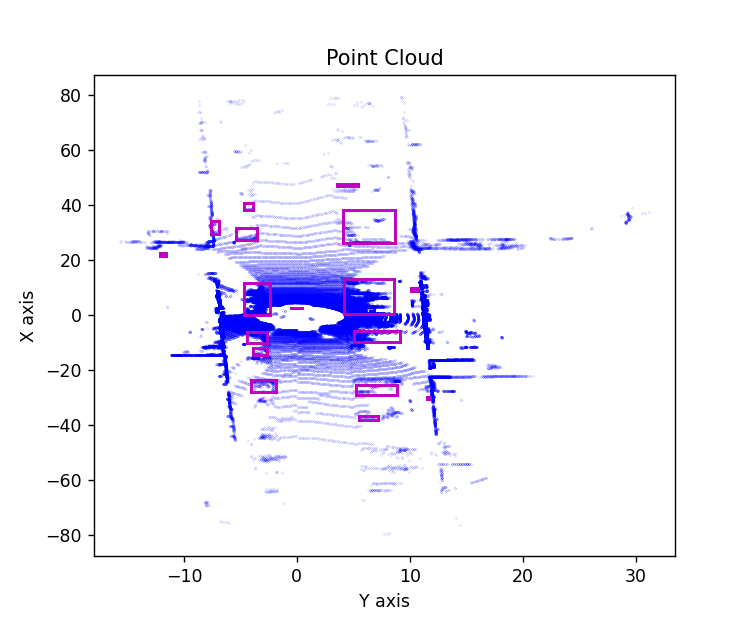

In [31]:
f = plt.figure(figsize=(6, 5))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw_point_cloud(scan, ax, 'Point Cloud',axes=axes)
for box in box_coord_list:
     draw_box(ax, box, axes=axes, color='m')

In [32]:
%time cloud = get_selected_segs(scan, label, obstacle_lst)

CPU times: user 774 ms, sys: 0 ns, total: 774 ms
Wall time: 780 ms


In [33]:
cloud

PyntCloud
19133 points with 2 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 1.5199661254882812, 0.5883350372314453, -0.8308182954788208
Other attributes:

In [34]:
spoints = cloud.points[['x','y','z']]

<IPython.core.display.Javascript object>


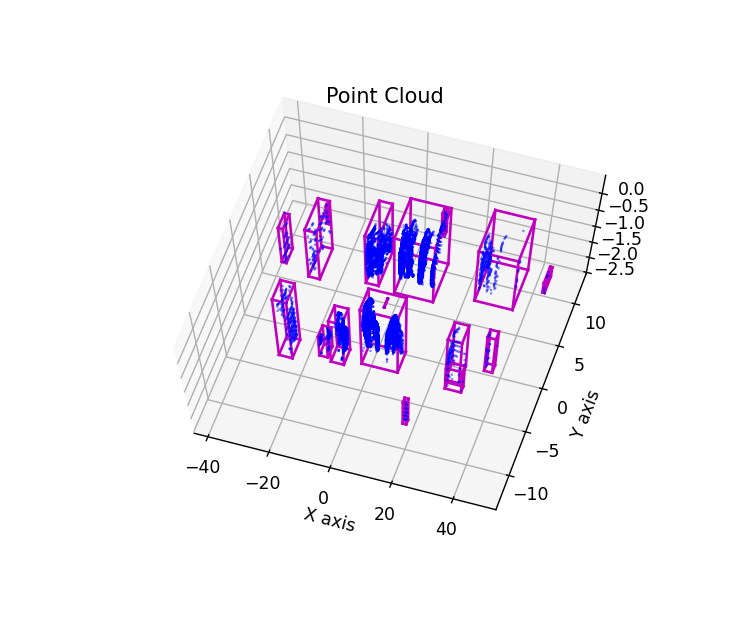

In [35]:
%matplotlib notebook
f = plt.figure(figsize=(6, 5))
axes = [0,1,2]
ax = f.add_subplot(111, projection='3d') 
# ax = f.add_subplot(111) 
draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes)
for box in box_coord_list:
     draw_box(ax, box, axes=axes, color='m')

## Getting bounding boxes for sequence 00

In [670]:
import glob
scan_lst = glob.glob("dataset/sequences/00/velodyne/*.bin")
labels_lst = glob.glob("dataset/sequences/00/labels/*.label")
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  459


In [674]:
# getting num of scan
import re
def get_scan_id(scan):
    return re.findall(r'\d\d\d\d\d.', scan)[0]

print(scan_lst[0])
print(get_scan_id(scan_lst[0]))

dataset/sequences/00/velodyne/000355.bin
000355


In [672]:
%%time
# get bboxes
for scan, label in zip(sorted(scan_lst), sorted(labels_lst)):
    
    # sanity check
    scan_id = get_scan_id(scan)
    assert scan_id == get_scan_id(label)
    
    # read scan
    scan = np.fromfile(scan, dtype=np.float32)
    scan = scan.reshape((-1, 4))[:, :3]

    # read label
    label = np.fromfile(label, dtype=np.uint32)
    label = label.reshape((-1))
    
    # start pipeline 
    clusters = pipeline(scan, label, obstacle_lst)
    
    # write cluster in format x_min, x_max, y_min, y_max, z_min, z_max
    np.savetxt('dataset/sequences/00/clusters/' + str(scan_id) + '.bbox', clusters)

get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding

get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes
get bounding boxes


Empty DataFrame
Columns: [(x, a), (x, b)]
Index: []

In [86]:
# def clustering(cloud, tol, min_size, max_size):
#     """
#     Input parameters:
#         cloud: Input cloud
#         tol: tolerance
#         min_size: minimal number of points to form a cluster
#         max_size: maximal number of points that a cluster allows 
#     Output:
#         cluster_indices: a list of list. Each element list contains the indices of the points that belongs to
#                          the same cluster
#     """
#     tree = cloud.make_kdtree()
#     ec = cloud.make_EuclideanClusterExtraction()
#     ec.set_ClusterTolerance(tol)
#     ec.set_MinClusterSize(min_size)
#     ec.set_MaxClusterSize(max_size)
#     ec.set_SearchMethod(tree)
#     cluster_indices = ec.Extract()
#     return cluster_indices